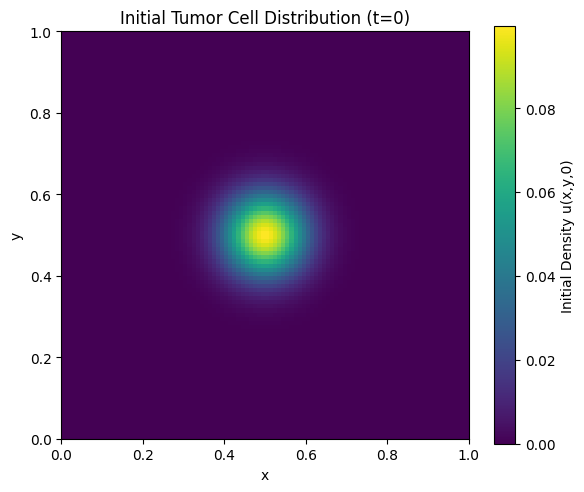

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import factorized

Lx, Ly = 1.0, 1.0
Nx, Ny = 100, 100
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)
x, y = np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')
dt, T_final = 0.01, 20.0
Nt = int(T_final / dt)
D = 0.01
N = Nx * Ny

def initial_condition(x, y):
    return 0.1 * np.exp(-100 * ((x - 0.5)**2 + (y - 0.5)**2))

u_initial = initial_condition(X, Y)
plt.figure(figsize=(6,5))
plt.imshow(u_initial, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis')
plt.colorbar(label='Initial Density u(x,y,0)')
plt.title('Initial Tumor Cell Distribution (t=0)')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

dx2, dy2 = dx**2, dy**2
main_diag_val = -2 / dx2 - 2 / dy2
y_deriv_coeff = 1 / dy2
x_deriv_coeff = 1 / dx2

A = diags(
    [main_diag_val * np.ones(N),
     y_deriv_coeff * np.ones(N - 1),
     y_deriv_coeff * np.ones(N - 1),
     x_deriv_coeff * np.ones(N - Ny),
     x_deriv_coeff * np.ones(N - Ny)],
    [0, -1, 1, -Ny, Ny],
    shape=(N, N),
    format='csr'
)

In [31]:
def m_center_hotspot(x, y):
    return 1.0 + 0.8 * np.exp(-100 * ((x - 0.5)**2 + (y - 0.5)**2))

def m_uniform(x, y):
    return np.ones_like(x)

def c_uniform(x, y):
    return np.ones_like(x)

def c_edge_crowding(x, y):
    return 1.0 + 2.0 * ((x - 0.5)**2 + (y - 0.5)**2)

def m_enriched_niche(x, y):
    return 1.0 + 1.5 * np.exp(-200 * ((x - 0.7)**2 + (y - 0.3)**2))

def c_unsustainable(x, y):
    return 3.0 - 2.0 * np.exp(-200 * ((x - 0.7)**2 + (y - 0.3)**2))

def m_large_patch(x, y):
    return 1.0 + 0.8 * (((x - 0.3)**2 + (y - 0.5)**2) < 0.1**2)

def m_fragments(x, y):
    r = 0.1 / np.sqrt(3)
    return 1.0 + 0.8 * (
        (((x - 0.2)**2 + (y - 0.5)**2) < r**2) +
        (((x - 0.4)**2 + (y - 0.5)**2) < r**2) +
        (((x - 0.6)**2 + (y - 0.5)**2) < r**2)
    )

scenarios = [
    ("Uniform", m_uniform, c_uniform),
    ("Hotspot Growth", m_center_hotspot, c_uniform),
    ("Edge Crowding", m_uniform, c_edge_crowding),
    ("Enriched Niche", m_enriched_niche, c_unsustainable),
    ("Large Patch", m_large_patch, c_uniform),
    ("Fragmented Patches", m_fragments, c_uniform),
]

results, titles, metrics = [], [], []
all_masses, all_growth_rates, all_K_fields = [], [], []

for name, m_func, c_func in scenarios:
    m = m_func(X, Y)
    c = c_func(X, Y)
    K = m / c
    all_K_fields.append(K)

    u = initial_condition(X, Y)
    u_flat = u.flatten()
    masses = []

    lhs = diags([1.0], [0], shape=(N, N), format='csc') - dt * D * A
    solver = factorized(lhs)

    m_flat = m.flatten()
    c_flat = c.flatten()

    for _ in range(Nt):
        reaction = u_flat * (m_flat - c_flat * u_flat)
        rhs = u_flat + dt * reaction

        u_flat_new = solver(rhs)
        u = u_flat_new.reshape((Nx, Ny))

        # Apply Neumann BCs
        u[0, :] = u[1, :]
        u[-1, :] = u[-2, :]
        u[:, 0] = u[:, 1]
        u[:, -1] = u[:, -2]

        u_flat = u.flatten()

        masses.append(np.sum(u) * dx * dy)

    results.append(u.copy())
    titles.append(name)
    all_masses.append(masses)
    all_growth_rates.append(np.gradient(masses, dt))

    total_mass = masses[-1]
    max_u = np.max(u)
    spread_area = np.sum(u > 0.1) * dx * dy
    metrics.append((total_mass, max_u, spread_area))


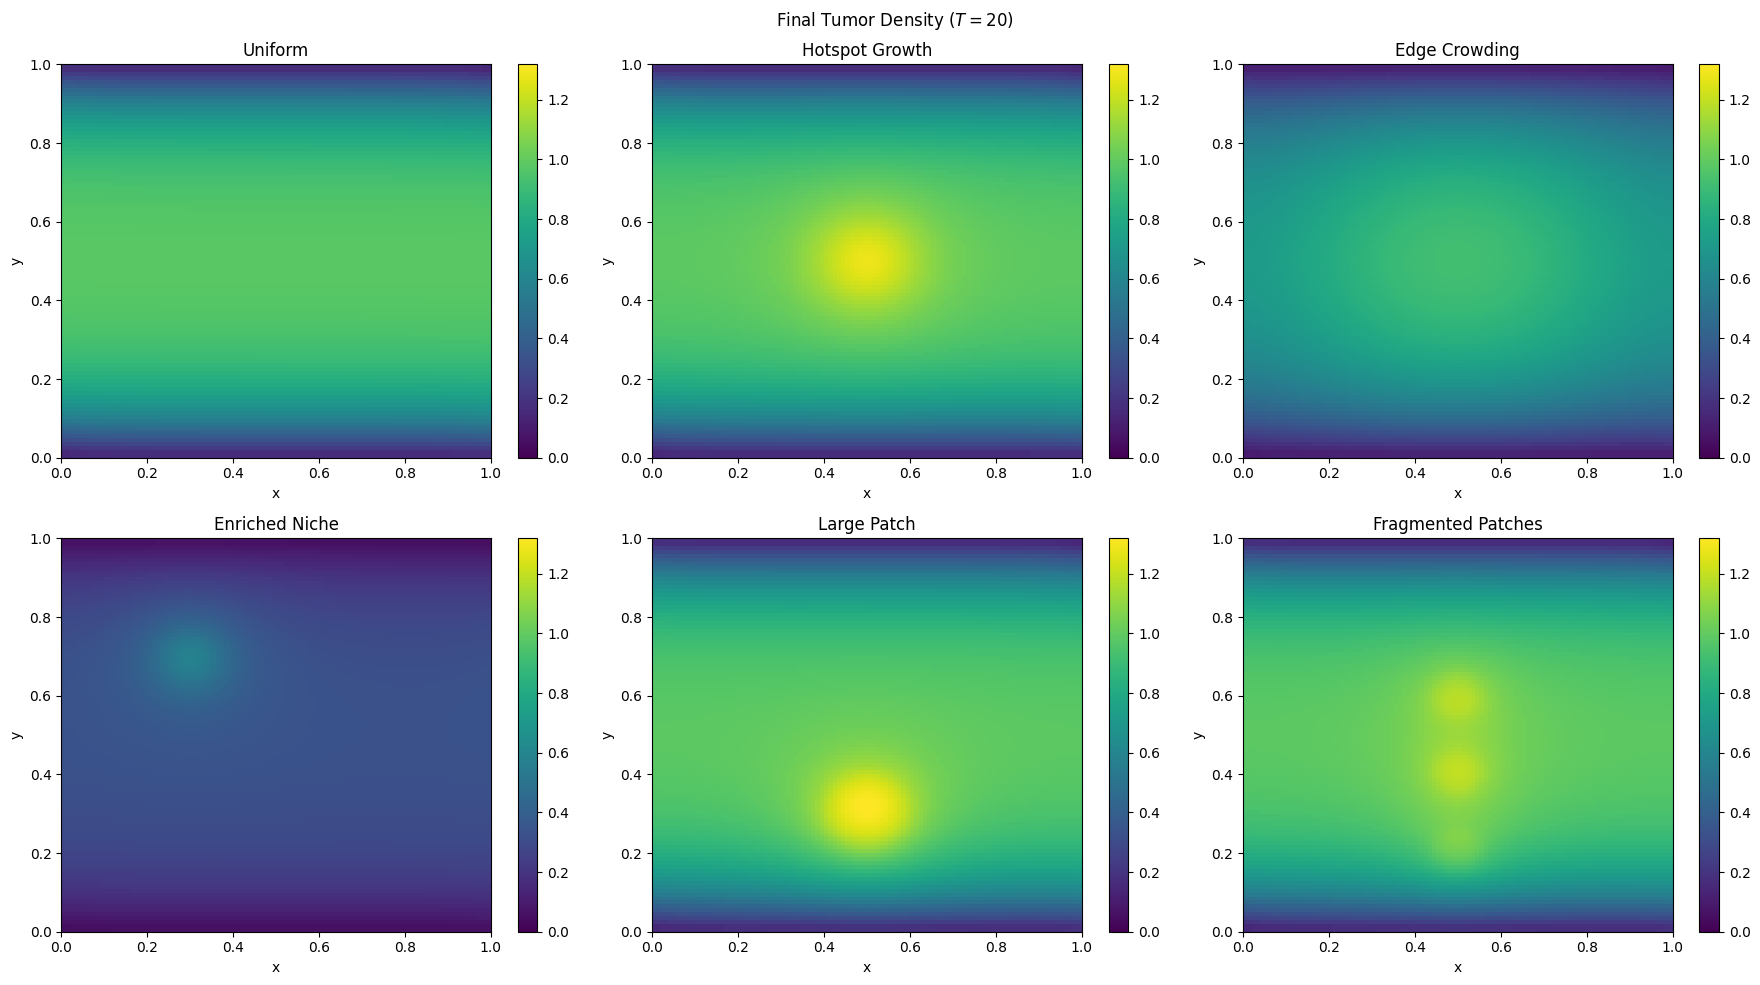

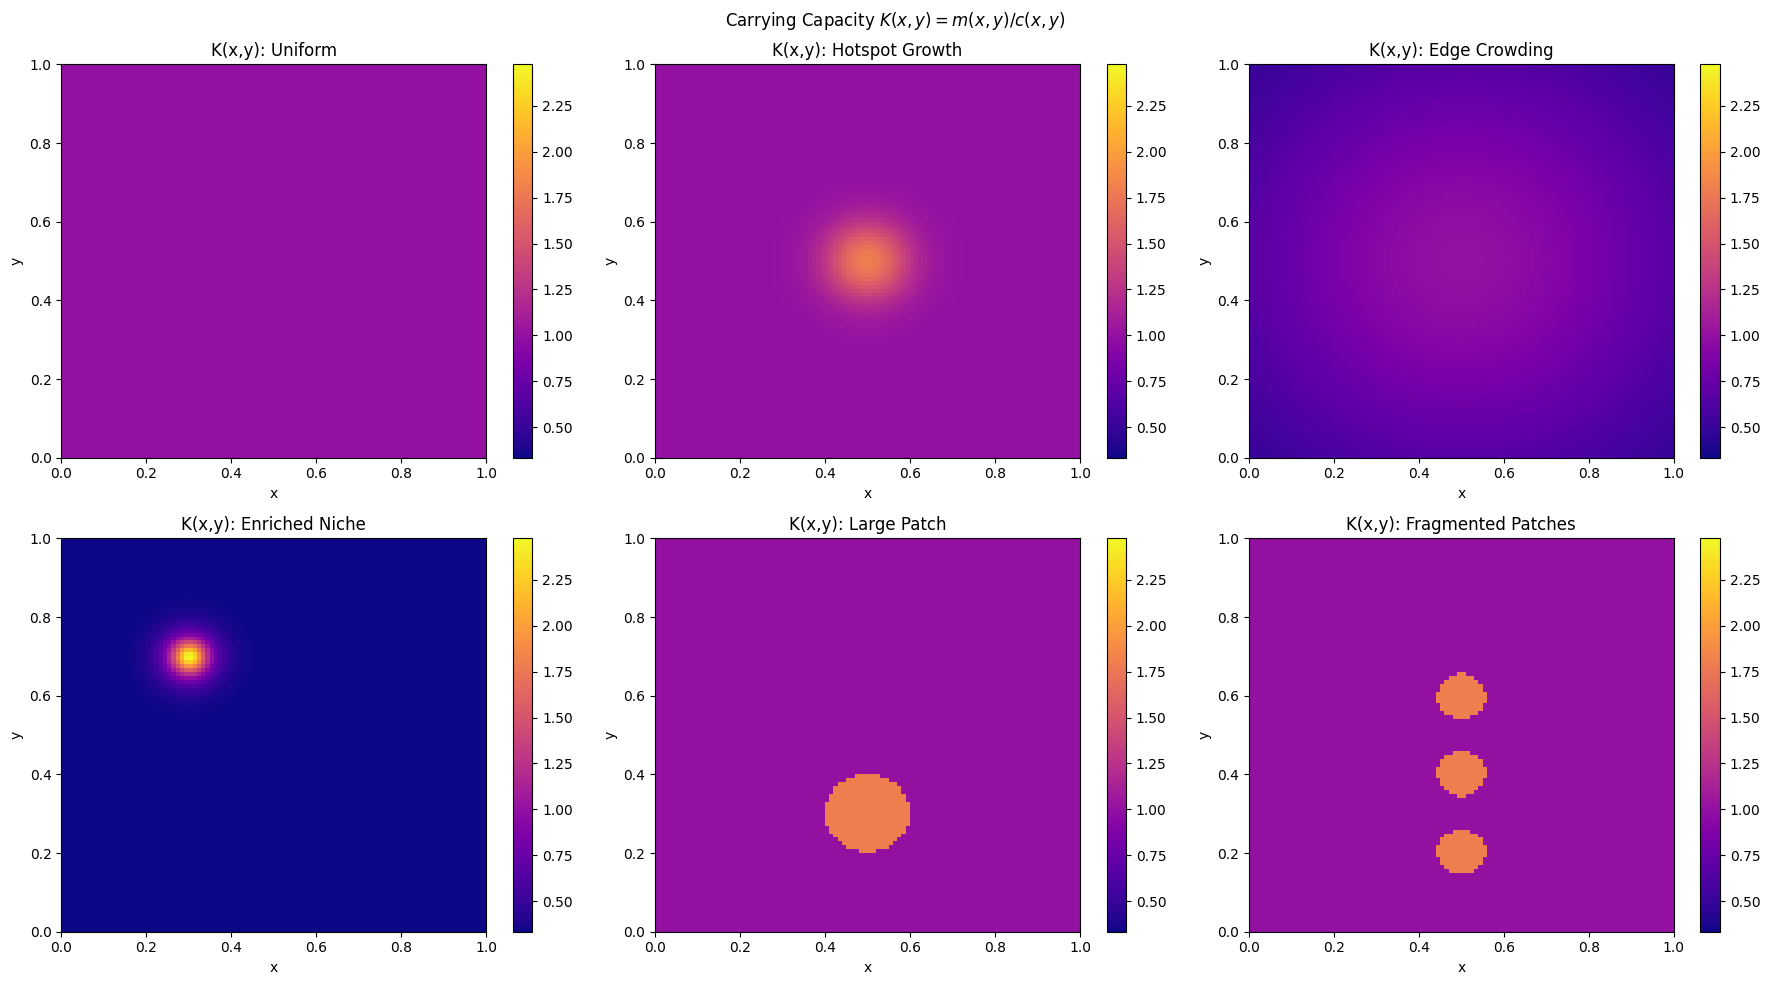

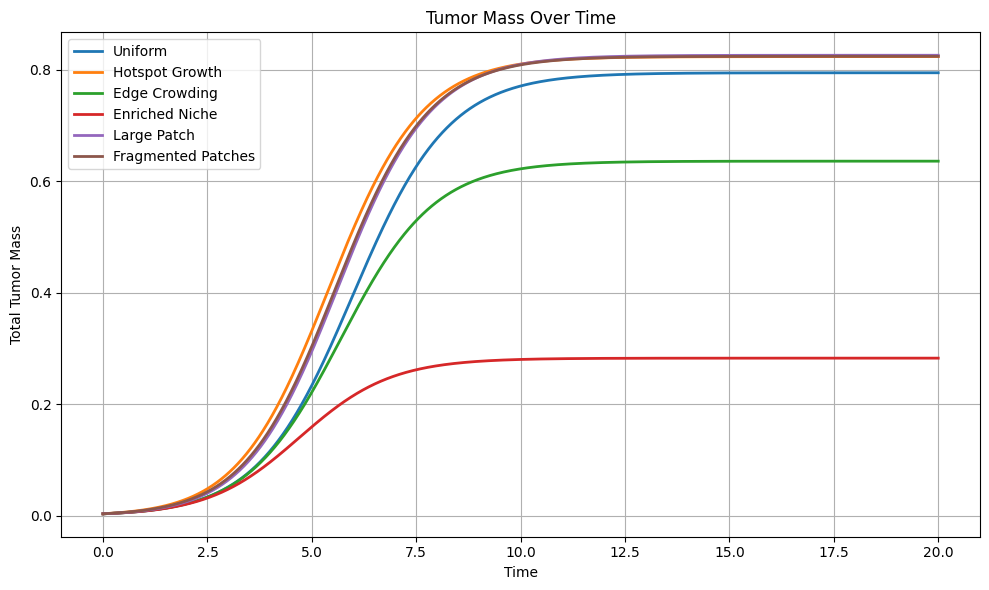

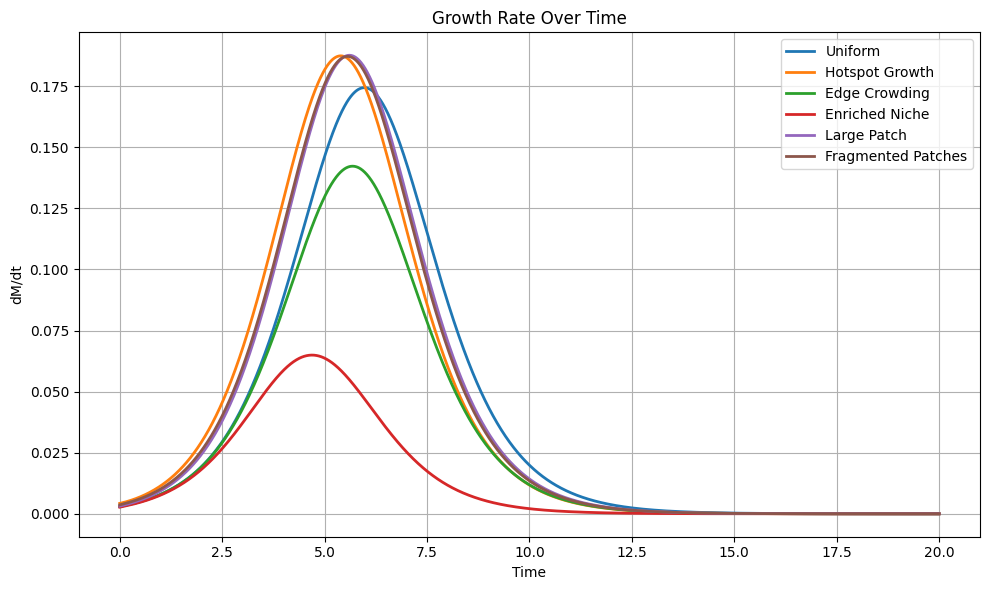


Summary Metrics (Final Time):

Scenario                    Total Mass      Max u     Spread Area
----------------------------------------------------------------------
Uniform                         0.7943     0.9821          1.0203
Hotspot Growth                  0.8233     1.2857          1.0203
Edge Crowding                   0.6357     0.9216          1.0195
Enriched Niche                  0.2824     0.5838          0.9443
Large Patch                     0.8257     1.3190          1.0203
Fragmented Patches              0.8238     1.1983          1.0203


In [32]:
# Final Tumor Density
fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
vmax_u = max(np.max(u) for u in results)
for i, ax in enumerate(axes1.flat):
    im = ax.imshow(results[i], origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],
                   vmin=0.0, vmax=vmax_u, cmap='viridis', aspect='auto')
    fig1.colorbar(im, ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
fig1.suptitle('Final Tumor Density ($T=20$)')
plt.tight_layout()
plt.show()

# Carrying Capacity
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 10))
kmin = min(np.min(K) for K in all_K_fields)
kmax = max(np.max(K) for K in all_K_fields)
if np.isclose(kmin, kmax):
    buffer = 0.1 * abs(kmin) + 1e-6
    kmin -= buffer
    kmax += buffer
for i, ax in enumerate(axes2.flat):
    im = ax.imshow(all_K_fields[i], origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],
                   vmin=kmin, vmax=kmax, cmap='plasma', aspect='auto')
    fig2.colorbar(im, ax=ax)
    ax.set_title(f'K(x,y): {titles[i]}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
fig2.suptitle('Carrying Capacity $K(x,y) = m(x,y)/c(x,y)$')
plt.tight_layout()
plt.show()

# Tumor Mass Over Time
plt.figure(figsize=(10, 6))
for i, mass in enumerate(all_masses):
    plt.plot(np.linspace(0, T_final, Nt), mass, label=titles[i], linewidth=2)
plt.xlabel('Time')
plt.ylabel('Total Tumor Mass')
plt.title('Tumor Mass Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tumor Growth Rate Over Time
plt.figure(figsize=(10, 6))
for i, growth in enumerate(all_growth_rates):
    plt.plot(np.linspace(0, T_final, Nt), growth, label=titles[i], linewidth=2)
plt.xlabel('Time')
plt.ylabel('dM/dt')
plt.title('Growth Rate Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary Table
print("\nSummary Metrics (Final Time):\n")
print(f"{'Scenario':<25} {'Total Mass':>12} {'Max u':>10} {'Spread Area':>15}")
print("-" * 70)
for title, (mass, max_u, area) in zip(titles, metrics):
    print(f"{title:<25} {mass:12.4f} {max_u:10.4f} {area:15.4f}")
